### Variational Autoencoder

In [1]:
!pip install pydotplus

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import numpy as np
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Layer, Reshape, Conv2DTranspose
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array

import numpy as np
import glob
import matplotlib.pyplot as plt

- Reparameterization trick

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

- Encoder

In [5]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.jpg', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      dense[0][0]                      
____________________________________________________________________________________________

- Decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(784, activation="relu")(x)
x = layers.Reshape((28, 28, 1))(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name = "decoder")
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.jpg', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 1)         10        
Total params: 666,394
Trainable params: 666,394
Non-trainable params: 0
_____________________________________________________

In [7]:
class VAE(keras.Model):
    def __init(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name = 'total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name = "reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name = 'kl_loss')
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            total_loss = reconstruction_loss * kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_trakcer.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }
        

In [8]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = Mean(name='total_loss')
        self.reconstruction_loss_tracker = Mean(name='reconstruction_loss')
        self.kl_loss_tracker = Mean(name='kl_lss')
        
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
    
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(data, reconstruction), axis=(1,2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss * kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()}

In [9]:
row, col = 28, 28

def preprocess_image(path):
    img = load_img(path, grayscale = True, target_size = (row, col))
    a = img_to_array(img).astype('float32')/255.
    a = np.expand_dims(a, axis = 0)
    return a

In [10]:
if __name__ == '__main__':
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if physical_devices:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(device=physical_devices[0], enable = True)
    
    train_dir = glob.glob('/Users/jh/Desktop/mnist/train/0/*.jpg')
    
    X_train = np.vstack([preprocess_image(fn) for fn in train_dir])
    
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [11]:
vae.fit(X_train, epochs=100, batch_size=128)

Epoch 1/100
39/39 [==============================] - 1s 34ms/step - loss: 90.1238 - reconstruction_loss: 384.4401 - kl_loss: 0.1707
Epoch 2/100
39/39 [==============================] - 1s 34ms/step - loss: 0.4227 - reconstruction_loss: 271.5336 - kl_loss: 0.0015
Epoch 3/100
39/39 [==============================] - 1s 34ms/step - loss: 0.2454 - reconstruction_loss: 258.8247 - kl_loss: 9.4243e-04
Epoch 4/100
39/39 [==============================] - 1s 34ms/step - loss: 0.1848 - reconstruction_loss: 251.4698 - kl_loss: 7.3214e-04
Epoch 5/100
39/39 [==============================] - 1s 34ms/step - loss: 0.1440 - reconstruction_loss: 246.5210 - kl_loss: 5.8322e-04
Epoch 6/100
39/39 [==============================] - 1s 37ms/step - loss: 0.1156 - reconstruction_loss: 242.8707 - kl_loss: 4.7392e-04
Epoch 7/100
39/39 [==============================] - 2s 43ms/step - loss: 0.0922 - reconstruction_loss: 239.5657 - kl_loss: 3.8415e-04
Epoch 8/100
39/39 [==============================] - 1s 35ms/s

39/39 [==============================] - 1s 34ms/step - loss: 0.0020 - reconstruction_loss: 220.1569 - kl_loss: 9.1043e-06
Epoch 62/100
39/39 [==============================] - 1s 36ms/step - loss: 0.0016 - reconstruction_loss: 220.0688 - kl_loss: 7.5006e-06
Epoch 63/100
39/39 [==============================] - 1s 34ms/step - loss: 0.0019 - reconstruction_loss: 220.1375 - kl_loss: 8.4754e-06
Epoch 64/100
39/39 [==============================] - 1s 35ms/step - loss: 0.0016 - reconstruction_loss: 220.0182 - kl_loss: 7.1146e-06
Epoch 65/100
39/39 [==============================] - 1s 35ms/step - loss: 0.0016 - reconstruction_loss: 219.8681 - kl_loss: 7.2195e-06
Epoch 66/100
39/39 [==============================] - 1s 34ms/step - loss: 0.0017 - reconstruction_loss: 220.1129 - kl_loss: 7.8871e-06
Epoch 67/100
39/39 [==============================] - 1s 35ms/step - loss: 0.0015 - reconstruction_loss: 219.9741 - kl_loss: 6.8196e-06
Epoch 68/100
39/39 [==============================] - 1s 34ms

In [12]:
vae.save_weights('Users/jh/Desktop/mnist/checkpoints/vae_mlp_mnist')

- 학습 확인

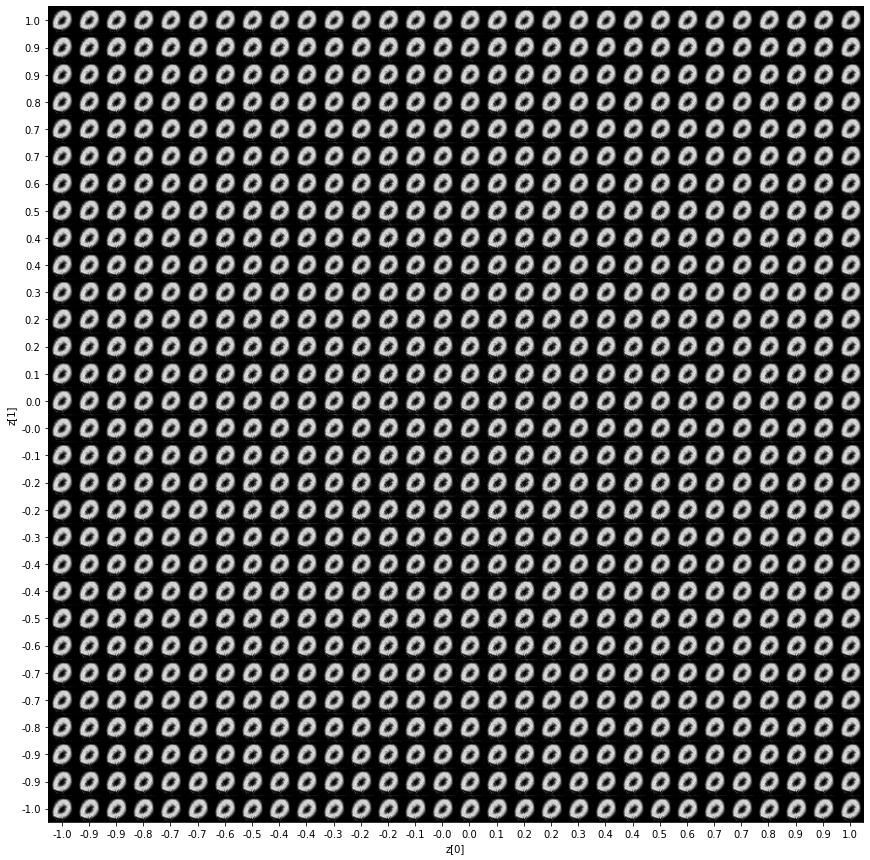

In [14]:
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
            
    
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
    
plot_latent_space(vae)

- Anomaly 테스트

In [15]:
input_shape = (28, 28, 1)

In [16]:
row, col = 28, 28
def preprocess_image(path):
    img = load_img(path, grayscale=True, target_size=(row, col))
    a = img_to_array(img).astype('float32')/255.
    a = np.expand_dims(a, axis = 0)
    return a

In [17]:
if __name__ == '__main__':
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if physical_devices:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(device=physical_devices[0], enable = True)

In [18]:
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.load_weights('Users/jh/Desktop/mnist/checkpoints/vae_mlp_mnist')
    test_data = preprocess_image('/Users/jh/Desktop/mnist/test/1/3.jpg')

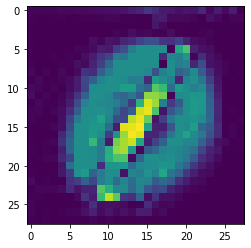

In [19]:
    pre_data = vae(data = test_data)
    diff_data = abs(pre_data - test_data)
    image = np.asarray(diff_data).squeeze()
    plt.imshow(image)

In [20]:
    anomaly_score = np.sum(diff_data)
    print(anomaly_score)

145.74724
